# Script to run pretrained BERT on reddit data

## Imports

In [1]:
try:
    import transformers
except ImportError as e:
    print('transformers not installed')
    print('Installing now...')
    !pip install -q git+https://github.com/huggingface/transformers.git
    pass

In [2]:
import reddit_bert_functions as fun
from bert_sarcasm_model import bert_for_sarcasm

In [3]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
import transformers
import json
from tqdm.notebook import tqdm
from transformers.utils.dummy_pt_objects import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification,AutoConfig, AutoModel,AutoTokenizer,BertModel,BertConfig,AdamW, get_constant_schedule,BertForSequenceClassification,get_linear_schedule_with_warmup
import random
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Import reddit dataset, split and create PyTorch data class objects

In [27]:
csv_path = 'train-balanced-sarcasm.csv'
x_train, y_train, x_val, y_val, x_test, y_test = fun.split_reddit_data(csv_path)

### Check distribution and word-count

Text(0.5, 1.0, 'Word counts per Reddit post')

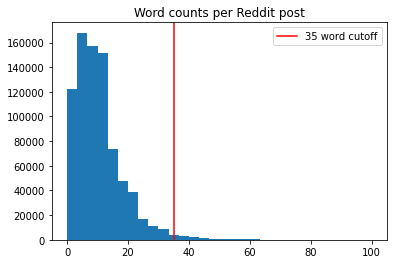

In [33]:
#word count per each sample
count = x_train.str.split().str.len()
plt.hist(count, bins=30, range=(0, 100))
plt.axvline(x = 35, color = 'r', label = '35 word cutoff')
plt.legend()
plt.title("Word counts per Reddit post")

Text(0.5, 1.0, 'Test Set')

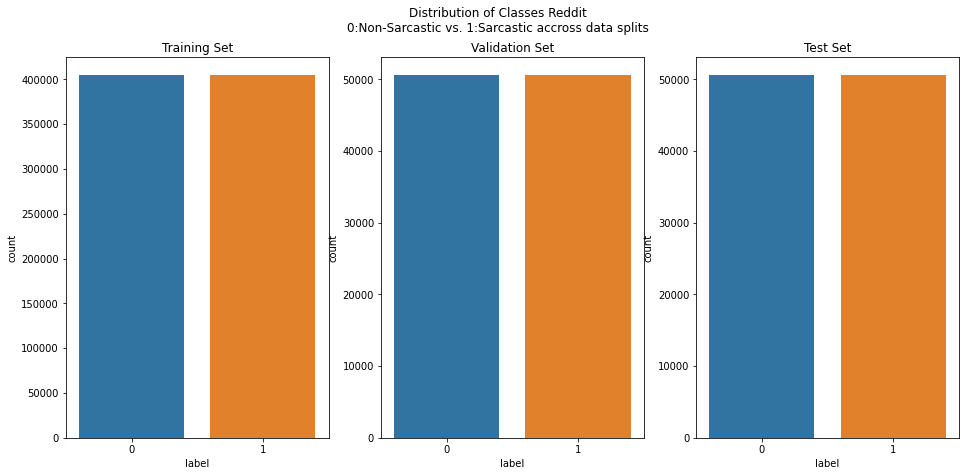

In [7]:
#check if even split between labels
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(16, 7))
fig.suptitle('Distribution of Classes Reddit\n0:Non-Sarcastic vs. 1:Sarcastic accross data splits')
sns.countplot(ax=axes[0], x=y_train)
axes[0].set_title('Training Set')
sns.countplot(ax=axes[1], x=y_val)
axes[1].set_title('Validation Set')
sns.countplot(ax=axes[2], x=y_test)
axes[2].set_title('Test Set')


### Tokenize

In [75]:
max_length = 100  #based on word count bar plot above, 35 is reasonable

#tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

reddit_train = fun.Reddit(x_train, y_train, tokenizer, max_length)
reddit_val = fun.Reddit(x_val, y_val, tokenizer, max_length)
reddit_test = fun.Reddit(x_test, y_test, tokenizer, max_length)

In [76]:
batch_size = 64
num_workers = 2
trainloader, validationloader, testloader = fun.get_data_loaders(reddit_train, reddit_val, reddit_test, batch_size, num_workers)


## Create BERT model

In [77]:
bertconfig = BertConfig()
#bert_large = BertModel.from_pretrained("bert-large-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Freeze all or part of params

In [78]:
#freeze params
#for param in bert.parameters():
    #param.requires_grad = False

fun.freeze_by_children(bert, 6)

The input model has 12 encoding layers
The model has 1 pooling layers
Bert layer 7 has been unfrozen
Bert layer 8 has been unfrozen
Bert layer 9 has been unfrozen
Bert layer 10 has been unfrozen
Bert layer 11 has been unfrozen
Bert layer 12 has been unfrozen
Pooling layer has been unfrozen


### Combine pretrained BERT with the rest of bert_for_sarcasm model

In [ ]:
recover = False
model_save_dir = "/projectnb/dl523/students/nannkat/Project/training/cp_100words.ckpt"

sarcasm_model = bert_for_sarcasm(bert)

if recover:
    #load weights from checkpoint if applicable
    checkpoint = torch.load(model_save_dir)
    sarcasm_model.load_state_dict(checkpoint['model_state_dict'])

sarcasm_model.to(device)

## Training

In [80]:
losses, val_losses = fun.train_reddit(sarcasm_model, trainloader, validationloader, 10, 
                                      batch_size, device,
                                      checkpoint=None, lr = 3e-5, model_save_dir = model_save_dir)

Epoch:  1
Elapsed [0:00:01], Iteration [1/12635]Loss: 0.7062
Elapsed [0:16:28], Iteration [2001/12635]Loss: 0.6592
Elapsed [0:32:56], Iteration [4001/12635]Loss: 0.4753
Elapsed [0:49:24], Iteration [6001/12635]Loss: 0.3915
Elapsed [1:05:52], Iteration [8001/12635]Loss: 0.5289
Elapsed [1:22:20], Iteration [10001/12635]Loss: 0.4079
Elapsed [1:38:48], Iteration [12001/12635]Loss: 0.5181
Validating.....


RuntimeError: CUDA out of memory. Tried to allocate 76.00 MiB (GPU 0; 11.91 GiB total capacity; 10.02 GiB already allocated; 67.25 MiB free; 10.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

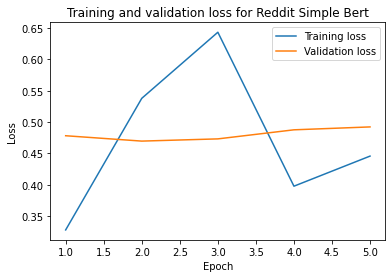

In [14]:
# Plot losses
epochs = range(1, len(losses) + 1)
plt.plot(epochs, losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss for Reddit Simple Bert')
plt.legend()
plt.show()

## Testing

In [8]:
def test_reddit(sarcasm_model, testloader, device):
    
    final_pred = []
    final_lab = []
    
    with torch.no_grad():
        test_correct = 0
        test_total = 0
        sarcasm_model.eval()
        for encodings, labels in testloader:
            inputs = encodings['input_ids']
            attention_mask = encodings['attention_mask']
            inputs, attention_mask = inputs.to(device), attention_mask.to(device)
            output = sarcasm_model(inputs,attention_mask).cpu()
            
            preds = torch.flatten(output)
            preds[preds<0.5] = 0
            preds[preds>=0.5] = 1
            test_correct += (preds == labels).float().sum().item()
            test_total += len(labels)
            
            preds = preds.numpy()
            l = labels.cpu().numpy()
            comp = l == preds
            final_lab.extend(l)
            final_pred.extend(preds)
    
    test_acc = round(test_correct/test_total,4)            
    print("Testing accuracy: {}".format(test_acc))
    
    return final_pred, final_lab, test_acc

In [ ]:
recover = True
model_save_dir = "/projectnb/dl523/students/nannkat/Project/training/cp_lr3e-5.ckpt"

bertconfig = BertConfig()
bert = BertModel.from_pretrained("bert-base-uncased")
sarcasm_model = bert_for_sarcasm(bert)

if recover:
    #load weights from checkpoint if applicable
    checkpoint = torch.load(model_save_dir)
    sarcasm_model.load_state_dict(checkpoint['model_state_dict'])

sarcasm_model.to(device)

In [21]:
print("With 6 unfrozen layers and lr 1e-5")
print()
final_pred, final_lab, test_acc = test_reddit(sarcasm_model, testloader, device)

With 6 unfrozen layers and lr 1e-5

Testing accuracy: 0.7736


### Stats

In [22]:
print("With 6 unfrozen layers and lr 3e-5")
print()
r_words = ["Sarcastic","Not Sarcastic"]
class_report = classification_report(final_lab,final_pred,target_names =r_words, digits =4)
print('\033[1m'+'Precision, Recall and Accuracy for Reddit Data:\n')
print(class_report)

With 6 unfrozen layers and lr 3e-5

Precision, Recall and Accuracy for Reddit Data:

               precision    recall  f1-score   support

    Sarcastic     0.7702    0.7799    0.7750     50540
Not Sarcastic     0.7771    0.7674    0.7722     50537

     accuracy                         0.7736    101077
    macro avg     0.7737    0.7736    0.7736    101077
 weighted avg     0.7737    0.7736    0.7736    101077



## Examples

### Reddit

In [11]:
max_length = 35  #based on word count bar plot above, 35 is reasonable
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
label_meanings = {0:"Non-Sarcastic", 1:"Sarcastic"}

In [40]:
#make pd arrays more comfy
x_test2 = x_test.reset_index(drop=True)
y_test2 = y_test.reset_index(drop=True)

In [74]:
start = 0
end = 8
text_examples = x_test2[start:end]
label_examples = y_test2[start:end]


inputs = tokenizer.batch_encode_plus(text_examples.tolist(), max_length = max_length,\
                                                          padding = True, truncation = True, \
                                                           add_special_tokens = True, return_tensors = "pt", \
                                                          return_attention_mask = True)

with torch.torch.no_grad():
    input_text = inputs['input_ids']
    attn_mask = inputs['attention_mask']
    input_text, attn_mask = input_text.to(device), attn_mask.to(device)
    output = sarcasm_model(input_text, attn_mask).cpu()
    preds = torch.flatten(output)
    preds[preds<0.5] = 0
    preds[preds>=0.5] = 1

print()
print("---------------------------------------------------------------------------")
print()
for i in range(8):
    print("'{}'".format(x_test2[start + i]))
    print()
    print("Predicted label: {} | Correct label: {}".format(label_meanings[int(preds[i])], label_meanings[y_test2[start + i]]))
    #print("Correct label: {} ".format(label_meanings[y_test2[i]]))
    print()
    print("---------------------------------------------------------------------------")
    print()
    
    



---------------------------------------------------------------------------

'In my head I'm a big bad berserker standing at 6'5 and what not, but in real life I feel like I'd be more of a priest class just cause I would be more worried about my friends getting hurt than I would be worried about axing any knaves.'

Predicted label: Non-Sarcastic | Correct label: Non-Sarcastic

---------------------------------------------------------------------------

'Girls are born insecure about their weight, didn't you know?'

Predicted label: Sarcastic | Correct label: Sarcastic

---------------------------------------------------------------------------

'I swear to fsm if they rape him like they did in the crystal skull...'

Predicted label: Sarcastic | Correct label: Non-Sarcastic

---------------------------------------------------------------------------

'Define "very bright".'

Predicted label: Non-Sarcastic | Correct label: Non-Sarcastic

-------------------------------------------------

### Headlines

In [22]:
class bert_for_sarcasm(nn.Module):

    def __init__(self,input_model, linear1 = 512, linear2 = 128,drop = .25, mod_type = 'binary',bert_model = 'bert-base-uncased'):
        super(bert_for_sarcasm,self).__init__()
        # Assumes size parameters of bert-base-uncased
        self.mod_type = mod_type
        self.bert_model = bert_model
        if self.bert_model == 'bert-base-uncased':
            self.model_size = 768
        else:
            self.model_size = 1024
        self.input_model = input_model
        
        self.linear = nn.Linear(self.model_size,linear1)
        
        self.linear2 = nn.Linear(linear1,linear2)
        
        self.linear3 = nn.Linear(linear2,2)
        
        self.linear3_binary = nn.Linear(linear2,1)
        
        self.relu = nn.ReLU()
        
        self.log = nn.LogSoftmax(dim = 1)

        self.dropout = nn.Dropout(drop)
        
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self,input_values,attention_mask):
   
        _,output = self.input_model(input_values, attention_mask=attention_mask).values()
        
        output = self.linear(output)

        output = self.dropout(output)
        
        output = self.relu(output)
        
        output = self.linear2(output)

        output = self.dropout(output)
        
        output = self.relu(output)
        
        if self.mod_type == 'binary':
            output = self.linear3_binary(output)
            output = self.sigmoid(output)
        else:
            output = self.linear3(output)
            output = self.log(output)

        
        return output
    
    
#Put updated sarcasm model on GPU
bertconfig = BertConfig()
bert = BertModel.from_pretrained("bert-base-uncased")
sarcasm_model_headlines = bert_for_sarcasm(bert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
sarcasm_model_headlines.load_state_dict(torch.load("/projectnb/dl523/projects/Sarcasm/Sarcasm_Models/sarcasm_bert.pth"))
sarcasm_model_headlines.eval()
sarcasm_model_headlines.to(device)

bert_for_sarcasm(
  (input_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [6]:
#Reading in the data
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json",lines = True)
df = df.rename(columns={'is_sarcastic': 'label'})
df = df.drop('article_link', 1)
df.head()

,label,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [7]:
train_headlines, temporary_text, train_label, temporary_label = train_test_split(df['headline'], df['label'], 
                                                                    random_state=200, 
                                                                    test_size=0.2, 
                                                                    stratify=df['label'])







validation_headlines, test_headlines, validation_label, test_label = train_test_split(temporary_text, temporary_label, 
                                                                    random_state=200, 
                                                                    test_size=0.5, 
                                                                    stratify=temporary_label)

test_headlines.head()
test_label.head()

17568    1
821      1
13447    1
26526    0
2216     1
Name: label, dtype: int64

In [8]:
test_headlines2 = test_headlines.reset_index(drop=True)
test_label2 = test_label.reset_index(drop=True)

In [9]:
print(test_headlines2)
print(test_label2)

0            lucky dead student gets own page in yearbook
1         google's 9/11 homepage design stirs controversy
2       walgreens to begin keeping most valuable emplo...
3       9 harrowing images that capture the lasting im...
4       experts say puerto rico still extremely vulner...
                              ...                        
2857    trump associates face growing concern and frus...
2858           grown adult walks right into karate studio
2859    'on fleek' viral star peaches monroee just lau...
2860    bill clinton: trump attacks on hillary clinton...
2861      dolphins chatter more when solving tricky tasks
Name: headline, Length: 2862, dtype: object
0       1
1       1
2       1
3       0
4       1
       ..
2857    0
2858    1
2859    0
2860    0
2861    0
Name: label, Length: 2862, dtype: int64


In [33]:
start = 56
end = 64
text_examples = test_headlines2[start:end]
label_examples = test_label2[start:end]


inputs = tokenizer.batch_encode_plus(text_examples.tolist(), max_length = max_length,\
                                                          padding = True, truncation = True, \
                                                           add_special_tokens = True, return_tensors = "pt", \
                                                          return_attention_mask = True)

with torch.torch.no_grad():
    input_text = inputs['input_ids']
    attn_mask = inputs['attention_mask']
    input_text, attn_mask = input_text.to(device), attn_mask.to(device)
    output = sarcasm_model_headlines(input_text, attn_mask).cpu()
    preds = torch.flatten(output)
    preds[preds<0.5] = 0
    preds[preds>=0.5] = 1

print()
print("---------------------------------------------------------------------------")
print()
for i in range(8):
    print("'{}'".format(test_headlines2[start + i]))
    print()
    print("Predicted label: {} | Correct label: {}".format(label_meanings[int(preds[i])], label_meanings[test_label2[start + i]]))
    #print("Correct label: {} ".format(label_meanings[y_test2[i]]))
    print()
    print("---------------------------------------------------------------------------")
    print()
    


---------------------------------------------------------------------------

'the best 'lazy games' for exhausted parents to play with their kids'

Predicted label: Non-Sarcastic | Correct label: Non-Sarcastic

---------------------------------------------------------------------------

'trance of 'unreal other''

Predicted label: Sarcastic | Correct label: Non-Sarcastic

---------------------------------------------------------------------------

'public theology and taylor swift'

Predicted label: Non-Sarcastic | Correct label: Non-Sarcastic

---------------------------------------------------------------------------

''goodell must go' banners flying over nfl stadiums'

Predicted label: Sarcastic | Correct label: Non-Sarcastic

---------------------------------------------------------------------------

'channing tatum and jenna dewan tatum slay on the golden globes red carpet'

Predicted label: Non-Sarcastic | Correct label: Non-Sarcastic

-----------------------------------------